In [121]:
import torch
import torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
from torch.nn.modules.loss import BCEWithLogitsLoss

from tqdm import tqdm
from tqdm.notebook import tqdm, trange
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import numpy as np
import time
import os
import cv2

from miw import MovieInputWrapper

In [122]:
device = "cuda" if torch.cuda.is_available() else "cpu"
traindir = "./data/train/"
testdir = "./data/valid/"

# Utility functions

In [123]:
def display_random_samples(training_dir_1, training_dir_2, nrows=4, ncols=4):
    samples_1 = [os.path.join(training_dir_1, np.random.choice(os.listdir(training_dir_1), 1)[0]) for _ in range(nrows * ncols // 2)]
    samples_2 = [os.path.join(training_dir_2, np.random.choice(os.listdir(training_dir_2), 1)[0]) for _ in range(nrows * ncols // 2)]
    samples = samples_1 + samples_2

    fig, ax = plt.subplots(nrows, ncols, figsize=(10, 10))
    ax = ax.flatten()

    for i in range(nrows * ncols):
        pic = plt.imread(samples[i])
        ax[i].imshow(pic)
        ax[i].set_axis_off()
    plt.show()

def plot_training(train_data, model_name):
    df_res = pd.DataFrame(train_data, columns=["train_loss", "train_acc", "valid_loss", "valid_acc"])
    fig, ax = plt.subplots(1, 2, figsize=(15, 8))
    ax[0].plot(df_res.train_loss, label='train')
    ax[0].plot(df_res.valid_loss, label='valid')
    ax[0].set_title(f'Training / validation loss')
    ax[0].set_ylabel('Loss', fontsize=16)
    ax[0].set_xlabel('Epoch', fontsize=16)

    ax[1].plot(df_res.train_acc, label='train')
    ax[1].plot(df_res.valid_acc, label='valid')
    ax[1].set_title(f'Training / validation accuracy')
    ax[1].set_ylabel('Accuracy', fontsize=16)
    ax[1].set_xlabel('Epoch', fontsize=16)

    plt.legend()
    fig.savefig(f'./models/training/{model_name}.png', dpi=fig.dpi)
    plt.show()
    return df_res

## Loading the dataset

In [124]:
# transformations
train_transforms = transforms.Compose([transforms.Resize((224, 224)),
                                       transforms.ToTensor(),
                                       torchvision.transforms.Normalize(
                                           mean=[0.485, 0.456, 0.406],
                                           std=[0.229, 0.224, 0.225],
                                       ),
                                       ])
test_transforms = transforms.Compose([transforms.Resize((224, 224)),
                                      transforms.ToTensor(),
                                      torchvision.transforms.Normalize(
                                          mean=[0.485, 0.456, 0.406],
                                          std=[0.229, 0.224, 0.225],
                                      ),
                                      ])

# datasets
train_data = datasets.ImageFolder(traindir, transform=train_transforms)
test_data = datasets.ImageFolder(testdir, transform=test_transforms)

# dataloader
train_loader = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=16)
val_loader = torch.utils.data.DataLoader(test_data, shuffle=True, batch_size=8)

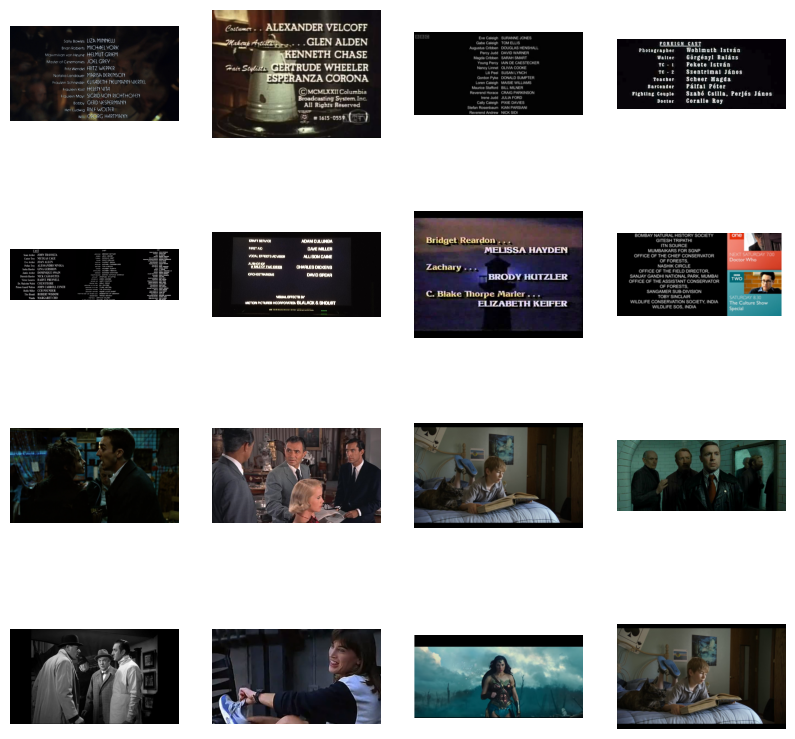

In [125]:
# Show random imgs from dataset credit / movie scene
display_random_samples(f"{traindir}/closing_credits", f"{traindir}/movie_screenshot")

In [126]:
print(f"Classes : {train_data.classes}")
print(f"Total training datapoints : {len(train_data)}")
print(f"Per classes (train): {train_data.targets.count(0)}, {train_data.targets.count(1)}")
print(f"Total val datapoints : {len(test_data)}")
print(f"Per classes (val): {test_data.targets.count(0)}, {test_data.targets.count(1)}")

Classes : ['closing_credits', 'movie_screenshot']
Total training datapoints : 400
Per classes (train): 190, 210
Total val datapoints : 100
Per classes (val): 48, 52


#### TODO find bigger dataset

# Training and eval functions

In [127]:
def check_accuracy(y_pred, y):
    num_correct = 0
    num_samples = 0
    with torch.no_grad():
      predictions = (y_pred > 0.5).long()
      num_correct += (predictions == y).sum()
      num_samples += predictions.size(0)
      acc = float(num_correct)/float(num_samples)
    return acc

In [128]:
def train(model, iterator, optimizer, criterion, device):
    epoch_loss = 0
    epoch_acc_1 = 0

    model.train()

    for (x, y) in tqdm(iterator, desc="Training", leave=False):

        x = x.to(device)
        y = y.to(device)
        y = y.unsqueeze(1).float()
        optimizer.zero_grad()

        y_pred = model(x)

        loss = criterion(y_pred, y)


        loss.backward()

        optimizer.step()
        acc = check_accuracy(y_pred, y)
        epoch_loss += loss.item()
        epoch_acc_1 += acc

    epoch_loss /= len(iterator)
    epoch_acc_1 /= len(iterator)
    return epoch_loss, epoch_acc_1


def evaluate(model, iterator, criterion, device):

    epoch_loss = 0
    epoch_acc_1 = 0

    model.eval()

    with torch.no_grad():

        for (x, y) in tqdm(iterator, desc="Evaluating", leave=False):

            x = x.to(device)
            y = y.to(device)
            y = y.unsqueeze(1).float()
            y_pred = model(x)

            loss = criterion(y_pred, y)
            acc = check_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc_1 += acc

    epoch_loss /= len(iterator)
    epoch_acc_1 /= len(iterator)

    return epoch_loss, epoch_acc_1


def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def start_training_and_eval(model, param: dict):
    if os.path.isfile(f'./models/{param["model"]}.pth'):
        print('[INFO]: Loading best model weights...')
        best_model = model.to(param["device"])
        best_model.load_state_dict(torch.load(f'./models/{param["model"]}.pth'))
        f, ax = plt.subplots(1, 1, figsize=(12, 12))
        img = mpimg.imread(f'./models/training/{param["model"]}.png')
        ax.imshow(img)
        ax.set_title("Training / Validation", fontsize=15)
        ax.axis('off')
        plt.show()
        return best_model
    else:
        EPOCHS = param["epochs"]
        best_valid_loss = float('inf')
        train_data = []
        for epoch in trange(EPOCHS, desc="Epochs"):

            start_time = time.monotonic()

            train_loss, train_acc_1 = train(model, train_loader, optimizer, criterion, device)
            valid_loss, valid_acc_1 = evaluate(model, val_loader, criterion, device)
            train_data.append([train_loss, train_acc_1, valid_loss, valid_acc_1])
            if valid_loss < best_valid_loss:
                best_valid_loss = valid_loss
                torch.save(model.state_dict(), f'./models/{param["model"]}.pth')

            end_time = time.monotonic()

            epoch_mins, epoch_secs = epoch_time(start_time, end_time)

            print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
            print(f'\tTrain Loss: {train_loss:.3f} | Train Acc @1: {train_acc_1*100:6.2f}% ')
            print(f'\tValid Loss: {valid_loss:.3f} | Valid Acc @1: {valid_acc_1*100:6.2f}% ')

        plot_training(train_data, param["model"])

# Baseline model

In [129]:
class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.dropout1 = nn.Dropout(p=0.5)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.dropout2 = nn.Dropout(p=0.5)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128 * 14 * 14, 512)  # Adjust the input size based on your input image size actual : (224, 224)
        self.dropout3 = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(512, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.pool1(torch.relu(self.conv1(x)))
        x = self.pool2(torch.relu(self.conv2(x)))
        x = self.dropout1(x)
        x = self.pool3(torch.relu(self.conv3(x)))
        x = self.dropout2(x)
        x = self.pool4(torch.relu(self.conv4(x)))
        x = self.flatten(x)
        x = torch.relu(self.fc1(x))
        x = self.dropout3(x)
        x = self.sigmoid(self.fc2(x))
        return x

In [130]:
param = {
    "model": "custom-cnn-model",
    "lr": 0.001,
    "batch_size": 16,
    "num_workers": 0,
    "epochs": 12,
    "device": "cuda"
}

In [131]:
custom_model = CustomCNN().to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.SGD(custom_model.parameters(), lr=param["lr"], momentum=0.9)
print(f'The model has {count_parameters(custom_model):,} trainable parameters')

The model has 13,086,913 trainable parameters


[INFO]: Loading best model weights...


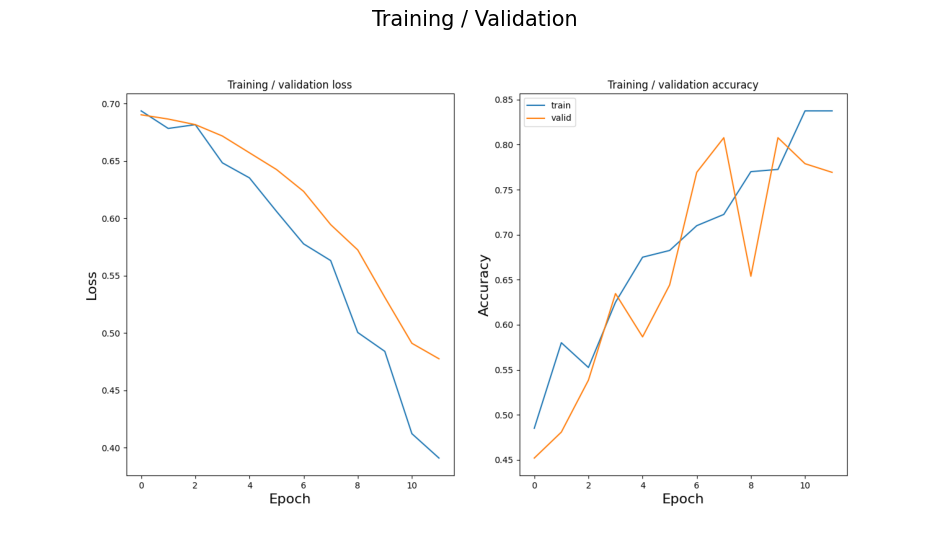

In [132]:
best_custom_model = start_training_and_eval(custom_model, param)

# Transfer learning model

note : as for now it's the quicker way to test the POC

In [133]:
param = {
    "model": "vit-model",
    "lr": 0.0001,
    "batch_size": 16,
    "num_workers": 0,
    "epochs": 6,
    "device": "cuda"
}

In [134]:
model_vit = models.vit_b_16(weights=models.ViT_B_16_Weights.DEFAULT).to(device)

In [135]:
# freeze all params
for params in model_vit.parameters():
    params.requires_grad_ = False
model_vit.heads = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=768,
                    out_features=1, # binary classification
                    bias=True)).to(device)

In [136]:
criterion = BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model_vit.parameters(), lr=param["lr"])
print(f'The model has {count_parameters(model_vit):,} trainable parameters')

The model has 85,799,425 trainable parameters


Epochs:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0m 11s
	Train Loss: 0.162 | Train Acc @1:  91.75% 
	Valid Loss: 0.160 | Valid Acc @1:  91.35% 


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 11s
	Train Loss: 0.056 | Train Acc @1:  96.75% 
	Valid Loss: 0.067 | Valid Acc @1:  97.12% 


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 0m 11s
	Train Loss: 0.034 | Train Acc @1:  98.75% 
	Valid Loss: 0.148 | Valid Acc @1:  96.15% 


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 11s
	Train Loss: 0.009 | Train Acc @1:  99.50% 
	Valid Loss: 0.165 | Valid Acc @1:  95.19% 


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 0m 11s
	Train Loss: 0.003 | Train Acc @1: 100.00% 
	Valid Loss: 0.111 | Valid Acc @1:  97.12% 


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 11s
	Train Loss: 0.001 | Train Acc @1: 100.00% 
	Valid Loss: 0.057 | Valid Acc @1:  97.12% 


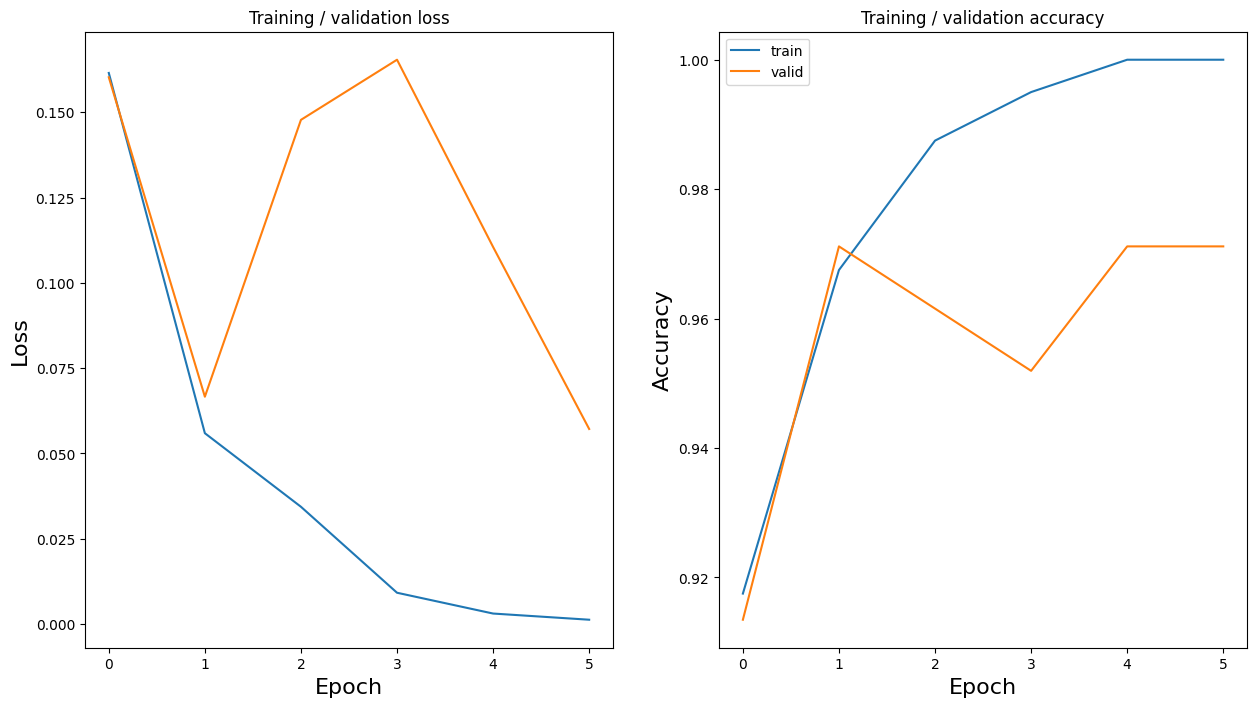

In [137]:
best_custom_model = start_training_and_eval(model_vit, param)

In [138]:
param = {
    "model": "resnet18-model",
    "lr": 0.001,
    "batch_size": 16,
    "num_workers": 0,
    "epochs": 8,
    "device": "cuda"
}

In [139]:
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

In [140]:
# freeze all params
for params in model.parameters():
    params.requires_grad_ = False

# add a new final layer
nr_filters = model.fc.in_features  # number of input features of last layer
model.fc = nn.Linear(nr_filters, 1)

model = model.to(device)

In [141]:
criterion = BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=param["lr"])
print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 11,177,025 trainable parameters


[INFO]: Loading best model weights...


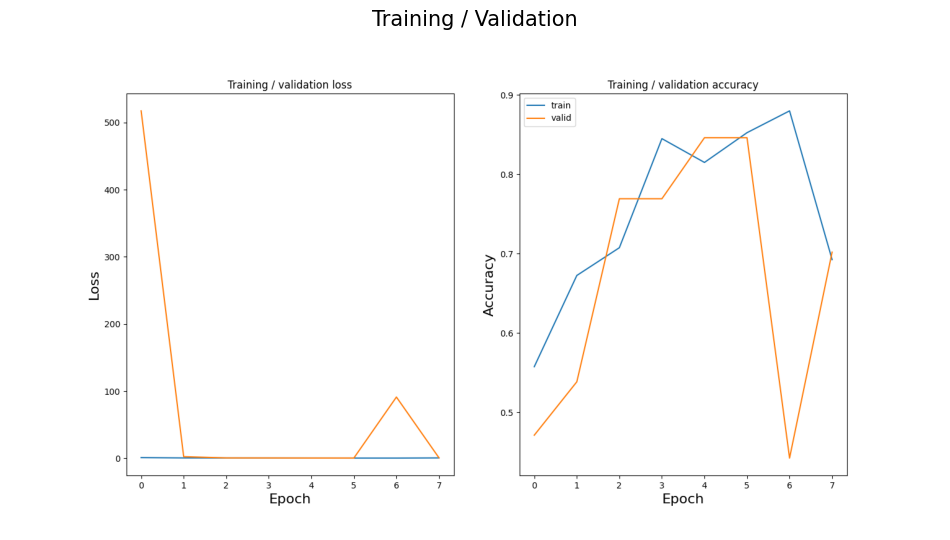

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [142]:
start_training_and_eval(model, param)

# Inference testing

In [153]:
# Change path to video accordingly
video_path = "/home/alex/Téléchargements/104913-001-A_v1080.mp4"

In [154]:
miw = MovieInputWrapper(video_path)

In [155]:
frame_set, metadata, credits_start_frame = miw.process_frames(model_vit)

In [156]:
print("Credits start at frame:", credits_start_frame['id'], f"at time : {credits_start_frame['time']}")

Credits start at frame: 46920.0 at time : 00:31:16.760


In [157]:
def show_frame(video_path, frame_number, mode='plt'):
    cap = cv2.VideoCapture(video_path)

    # Check if the video file is opened successfully
    if not cap.isOpened():
        print("Error: Could not open video file.")
        return

    # Set the frame position
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)

    # Read the frame
    ret, frame = cap.read()

    # Check if the frame is read successfully
    if not ret:
        print("Error: Could not read frame.")
        return

    # Release the video capture object
    cap.release()

    if mode == 'cv2':
        # Display the frame using OpenCV
        cv2.imshow("Frame", frame)
        cv2.waitKey(0)  # Wait until a key is pressed
        cv2.destroyAllWindows()
    elif mode == 'plt':
        # Plot the frame using Matplotlib
        plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.show()
    else:
        print("Error: Invalid mode. Please choose 'cv2' or 'plt'.")

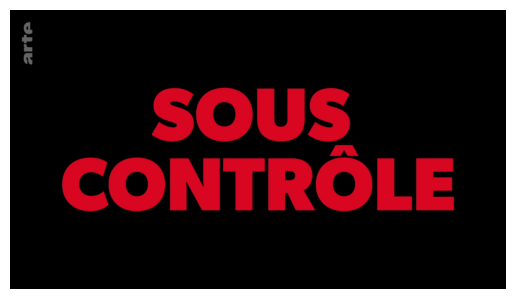

In [158]:
show_frame(video_path, credits_start_frame['id'])